# Demo for the DoWhy causal API
We show a simple example of adding a causal extension to any dataframe. 

In [1]:
import dowhy.datasets
import dowhy.api

import numpy as np
import pandas as pd

from statsmodels.api import OLS

keywords are unexpanded, not using


In [2]:
data = dowhy.datasets.linear_dataset(beta=5,
        num_common_causes=1,
        num_instruments = 0,
        num_samples=1000,
        treatment_is_binary=True)
df = data['df']
df['y'] = df['y'] + np.random.normal(size=len(df)) # Adding noise to data. Without noise, the variance in Y|X, Z is zero, and mcmc fails.
#data['dot_graph'] = 'digraph { v ->y;X0-> v;X0-> y;}'

treatment= data["treatment_name"][0]
outcome = data["outcome_name"][0]
common_cause = data["common_causes_names"][0]
df

,W0,v0,y
0,-0.909829,True,2.754562
1,0.209459,True,6.144004
2,-0.200867,True,4.799886
3,-2.286283,False,-6.587331
4,-0.477794,True,4.280700
...,...,...,...
995,0.755928,True,7.400020
996,-1.194904,False,-2.457084
997,-1.949665,False,-4.477591
998,0.111060,False,1.644849


<AxesSubplot:xlabel='v0'>

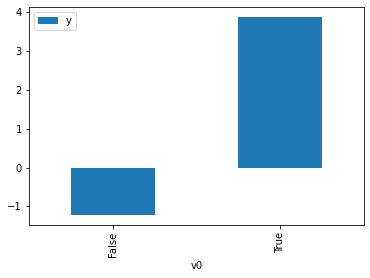

In [3]:
# data['df'] is just a regular pandas.DataFrame
df.causal.do(x=treatment,
                     variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'},
                     outcome=outcome,
                     common_causes=[common_cause],
                     proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

<AxesSubplot:xlabel='v0'>

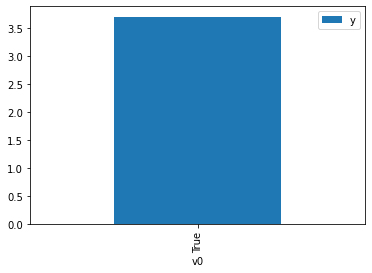

In [4]:
df.causal.do(x={treatment: 1}, 
              variable_types={treatment:'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome,
              method='weighting', 
              common_causes=[common_cause],
              proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

In [5]:
cdf_1 = df.causal.do(x={treatment: 1}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)

cdf_0 = df.causal.do(x={treatment: 0}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)


In [6]:
cdf_0

,W0,v0,y,propensity_score,weight
0,-1.667118,False,-1.411361,0.634019,1.577239
1,-0.394512,False,-1.111562,0.517117,1.933798
2,-0.220692,False,2.069921,0.500699,1.997208
3,-0.001738,False,2.813840,0.480020,2.083245
4,-1.094281,False,-1.353864,0.582485,1.716781
...,...,...,...,...,...
995,-0.850150,False,-0.046305,0.559889,1.786069
996,-0.143082,False,-0.799458,0.493366,2.026893
997,-0.028686,False,0.749287,0.482563,2.072267
998,-0.911424,False,-2.193269,0.565588,1.768073


In [7]:
cdf_1

,W0,v0,y,propensity_score,weight
0,-1.244185,True,1.536806,0.403803,2.476454
1,-2.558297,True,-1.720786,0.291867,3.426220
2,-1.503951,True,0.265153,0.380406,2.628772
3,-1.571306,True,2.108568,0.374424,2.670769
4,-0.081369,True,5.134562,0.512463,1.951359
...,...,...,...,...,...
995,-0.662244,True,3.539412,0.457679,2.184936
996,0.082794,True,5.341700,0.527949,1.894124
997,1.307028,True,8.502420,0.639831,1.562912
998,-0.859600,True,1.902208,0.439231,2.276705


## Comparing the estimate to Linear Regression
First, estimating the effect using the causal data frame, and the 95% confidence interval.

In [8]:
(cdf_1['y'] - cdf_0['y']).mean()

In [9]:
1.96*(cdf_1['y'] - cdf_0['y']).std() / np.sqrt(len(df))

Comparing to the estimate from OLS.

In [10]:
model = OLS(np.asarray(df[outcome]), np.asarray(df[[common_cause, treatment]], dtype=np.float64))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.935
Model:                            OLS   Adj. R-squared (uncentered):              0.935
Method:                 Least Squares   F-statistic:                              7186.
Date:                Sun, 07 Aug 2022   Prob (F-statistic):                        0.00
Time:                        22:09:58   Log-Likelihood:                         -1442.3
No. Observations:                1000   AIC:                                      2889.
Df Residuals:                     998   BIC:                                      2898.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             2.2804      0.030     77.056      0.000       2.222       2.338
x2             4.9881      0.048    104.326      0.000       4.894       5.082
==============================================================================
Omnibus:                        2.134   Durbin-Watson:                   2.007
Prob(Omnibus):                  0.344   Jarque-Bera (JB):                2.016
Skew:                           0.105   Prob(JB):                        0.365
Kurtosis:                       3.067   Cond. No.                         1.68
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""